<a href="https://colab.research.google.com/github/meliao/cluster_startup/blob/main/teacher_networks_linear_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import ortho_group
from scipy.stats import linregress
import torch.multiprocessing as mp
import queue
import time
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts, SequentialLR, MultiStepLR
import logging

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# helper funcs for training

## single epoch training func

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    trains one epoch
    """
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.flatten(), y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


## helper functions for weight decay only on weights, not on biases

In [ ]:
def add_weight_decay(model, weight_decay, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  #frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]


In [ ]:
def weight_decay_val(paramlist):
    """
    computes the value of the weight decay term after an epoch
    """
    sum = 0.
    for weight in paramlist[1]['params']:
        with torch.no_grad():
            sum += (weight**2).sum()
    return sum.item()

def weight_decay_eval(paramlist):
    """
    computes the value of the weight decay term after an epoch
    """
    sum = 0.
    for weight in paramlist[1]['params']:
        with torch.no_grad():
            sum += (weight**2).sum()
    return sum


## data generation function

In [ ]:
def gen_data(datasetsize,r,seed,trainsize=2**18,testsize=2**10,d=20,funcseed=42,verbose=False,ood=False,normal=False):
    ##Generate data with a true central subspaces of varying dimensions
    #generate X values for training and test sets
    np.random.seed(seed) #set seed for data generation
    if not normal:
      trainX = np.random.rand(d,trainsize).astype(np.float32)[:,:datasetsize] - 0.5 #distributed as U[-1/2, 1/2]
      testX = np.random.rand(d,testsize).astype(np.float32) - 0.5 #distributed as U[-1/2, 1/2]
    else:
      trainX = np.random.randn(d,trainsize).astype(np.float32)[:,:datasetsize] #distributed as N(0,1)
      testX = np.random.randn(d,testsize).astype(np.float32) #distributed as N(0,1)
    #out of distribution datagen
    if ood:
      trainX *= 2 #now distributed as U[-1, 1] or N(0,2)
      testX *= 2 #now distributed as U[-1, 1] or N(0,2)
    ##for each $r$ value create and store data-gen functions and $y$ evaluations
    #geneate params for functions
    k = d+1
    np.random.seed(funcseed) #set seed for random function generation
    U = ortho_group.rvs(k)[:,:r]
    Sigma = np.random.rand(r)*100
    V = ortho_group.rvs(d)[:,:r]
    W = (U * Sigma) @ V.T
    A = np.random.randn(k)
    B = np.random.randn(k)
    #create functions
    def g(z): #active subspace function
        hidden_layer = (U*Sigma)@z
        hidden_layer = hidden_layer.T + B
        hidden_layer = np.maximum(0,hidden_layer).T
        return A@hidden_layer
    def f(x): #teacher network
        z = V.T@x
        return g(z)
    #generate data
    trainY = f(trainX).astype(np.float32)
    testY = f(testX).astype(np.float32)
    #move data to device
    if verbose:
        print("device: {}".format(device))
    trainX = torch.from_numpy(trainX).T.to(device)
    trainY = torch.from_numpy(trainY).to(device)
    testX = torch.from_numpy(testX).T.to(device)
    testY = torch.from_numpy(testY).to(device)
    if verbose:
        print("trainX shape = {} trainY shape = {}".format(
            trainX.shape,
            trainY.shape
        ))
    return trainX,trainY,testX,testY


## model class

In [ ]:
def Llayers(L,d,width):
    #construct L-1 linear layers; bias term only on last linear layer
    if L < 2:
        raise ValueError("L must be at least 2")
    if L == 2:
        linear_layers = [nn.Linear(d,width,bias=True)]
    if L > 2:
        linear_layers = [nn.Linear(d,width,bias=False)]
        for l in range(L-3):
            linear_layers.append(nn.Linear(width,width,bias=False))
        linear_layers.append(nn.Linear(width,width,bias=True))

    relu = nn.ReLU()

    last_layer = nn.Linear(width,1)

    layers = linear_layers + [relu,last_layer]

    return nn.Sequential(*layers)


## full training function

In [ ]:
#scheduler=MultiStepLR,milestones=[30_000], gamma=0.1
def train_L_layers(datasetsize,L,r,weight_decay,epochs=30_100,lr=1e-4,
                   trainsize=2**18,testsize=2**10,d=20,funcseed=42,datagenseed=1,normal=False,
                   initseed=42,batch_size=64,width=1000,verbose=False,
                   no_wd_last_how_many_epochs=100,
                   scheduler=None,**schedulerkwargs):
    #start timer
    starttime = time.time()

    #generate data
    trainX,trainY,testX,testY = gen_data(datasetsize,r,datagenseed,trainsize,testsize,d,funcseed,verbose,normal=normal)

    #define pytorch dataloaders
    dataset = torch.utils.data.TensorDataset(trainX,trainY) #create your dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) #create your dataloader

    #initialize model
    torch.manual_seed(initseed) #set seed for initalization
    model = Llayers(L,d,width)
    model.to(device)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    num_params = sum([np.prod(p.size()) for p in model_parameters])

    loss_fn = nn.MSELoss()
    paramlist = add_weight_decay(model,weight_decay)
    optimizer = torch.optim.AdamW(paramlist, lr=lr)

    if verbose:
        print("lambda = {}".format(paramlist[1]['weight_decay']))

    #main training loop
    with torch.no_grad():
        trainmse = torch.zeros(epochs,device=device)
        weightdecay = torch.zeros(epochs,device=device)
        learningrate = torch.zeros(epochs,device=device)
    if verbose:
        printfreq = 100 if datasetsize > 500 else 500
    if verbose:
        print("Time: {:.1f} Starting to Train".format(
            time.time()-starttime
        ))
    if scheduler is not None:
        scheduler = scheduler(optimizer,**schedulerkwargs)
    flag = False
    for t in range(epochs):
        train(dataloader, model, loss_fn, optimizer)

        with torch.no_grad():
            #record current MSE, weight decay value, and learning rate
            trainmse[t] = loss_fn(model(trainX).flatten(),trainY) + weight_decay_eval(paramlist)
            for param in model.parameters():
                weightdecay[t] += weight_decay_val(paramlist)
            if scheduler is not None:
                learningrate[t] = scheduler.optimizer.param_groups[0]['lr']

            #report loss every few epochs
            if verbose:
                if t % printfreq == 0:
                    print("Time: {:.1f} Epoch: {} Train MSE:{:.6e} Weight Decay:{:.6e}".format(
                        time.time()-starttime,
                        t,
                        trainmse[t],
                        weightdecay[t]
                    ))

        #adjust learning rate
        if scheduler is not None:
            scheduler.step()

        #turn off weight decay for last 100 epochs
        if flag is False and t > epochs - no_wd_last_how_many_epochs:
            optimizer.param_groups[1]['weight_decay'] = 0
            flag = True

    #report loss at end of training
    with torch.no_grad():
        testmse = loss_fn(model(testX).flatten(),testY).detach().cpu().numpy()
        if verbose:
            print("Time: {:.1f} Test MSE:{:.6e} Train MSE:{:.6e} Weight Decay:{:.6e}".format(
                time.time()-starttime,
                testmse,
                trainmse[t],
                weightdecay[t]
            ))

    result_dict = {
        'model':model,
        'trainmse':trainmse,
        'weightdecay':weightdecay,
        'learningrate':learningrate,
        'testmse':testmse
    }

    return result_dict

# training

## GPU

In [ ]:
# check GPU is enabled
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Wed Aug  2 22:16:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
starttime = time.time()

## $r = 1, N = 64$

### training for each value of lambda

In [ ]:
# wds = np.logspace(-5,-3,num=3)
wds = [1e-3]
print(wds)
r = 1
datasetsize = 64
print(f"r = {r}, N = {datasetsize}")
res = {}
for L in [2,4]:
    print(f"~~L = {L}~~")
    res[L] = {}
    for wd in wds:
        result = train_L_layers(datasetsize,L,r,weight_decay=wd,epochs=30_100,normal=False,
                                lr=1e-4,scheduler=MultiStepLR,milestones=[30_000], gamma=0.1,verbose=False)
        res[L][wd] = result
        print(f"weight decay {wd:.2e}, test mse {result['testmse']:.6e} final train mse {result['trainmse'][-1].item():.6e}")


[0.001]
r = 1, N = 64
~~L = 2~~
weight decay 1.00e-03, test mse 4.765840e+00 final train mse 1.321344e-14
~~L = 4~~
weight decay 1.00e-03, test mse 1.173315e-01 final train mse 3.463536e-12


### saving results

In [ ]:
path = f"gdrive/MyDrive/TeacherNetworkResults/normaldist"
for value_to_save in ['trainmse','weightdecay','learningrate','testmse']:
    print(value_to_save)
    value_dict = {L:{} for L in [2,4]}
    for L in [2,4]:
        for wd in wds:
            print(L,wd)
            if type(res[L][wd][value_to_save]) == torch.Tensor:
                value = res[L][wd][value_to_save].clone().detach().cpu().numpy()
            else:
                value = res[L][wd][value_to_save].copy()
            value_dict[L][wd] = value
    np.save(f"{path}{value_to_save}_r{r}_N{datasetsize}",value_dict)
#save trained models
value_dict = {L:{} for L in [2,4]}
print('models')
for L in [2,4]:
    for wd in wds:
        print(L,wd)
        model = res[L][wd]['model'].cpu()
        torch.save(model.state_dict(), f"{path}model_r{r}_N{datasetsize}_L{L}_wd{wd}")

trainmse
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
weightdecay
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
learningrate
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
testmse
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
models
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001


### training plots

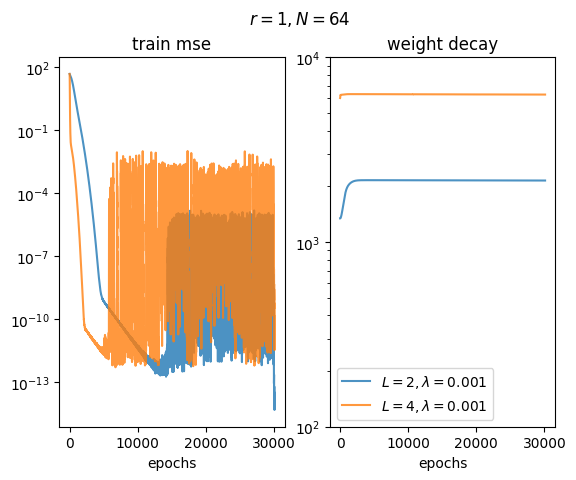

In [ ]:
optimalL2wd = 1e-3 # CHOOSE MANUALLY
optimalL4wd = 1e-3 # CHOOSE MANUALLY
alpha = 0.8
plt.subplot(121)
plt.semilogy(res[2][optimalL2wd]['trainmse'].cpu(),alpha=alpha)
plt.semilogy(res[4][optimalL4wd]['trainmse'].cpu(),alpha=alpha)
plt.title("train mse")
plt.xlabel("epochs")
plt.subplot(122)
plt.semilogy(res[2][optimalL2wd]['weightdecay'].cpu(),label=rf"$L = 2,\lambda = {optimalL2wd}$",alpha=alpha)
plt.semilogy(res[4][optimalL4wd]['weightdecay'].cpu(),label=rf"$L = 4,\lambda = {optimalL4wd}$",alpha=alpha)
plt.title('weight decay')
plt.ylim(1e2,1e4)
plt.xlabel("epochs")
plt.suptitle(rf"$r = {r}, N = {datasetsize}$")
plt.legend()

## $r = 2, N = 64$

### training for each value of lambda

In [ ]:
wds = np.logspace(-5,-3,num=3)
print(wds)
r = 2
datasetsize = 64
print(f"r = {r}, N = {datasetsize}")
res = {}
for L in [2,4]:
    print(f"~~L = {L}~~")
    res[L] = {}
    for wd in wds:
        result = train_L_layers(datasetsize,L,r,weight_decay=wd,epochs=50_100,normal=True,
                                lr=1e-4,scheduler=MultiStepLR,milestones=[50_000], gamma=0.1,verbose=False)
        res[L][wd] = result
        print(f"weight decay {wd:.2e}, test mse {result['testmse']:.6e} final train mse {result['trainmse'][-1].item():.6e}")


[1.e-05 1.e-04 1.e-03]
r = 2, N = 64
~~L = 2~~
weight decay 1.00e-05, test mse 1.195923e+02 final train mse 9.650558e-12
weight decay 1.00e-04, test mse 1.114598e+02 final train mse 6.159032e-12
weight decay 1.00e-03, test mse 1.092997e+02 final train mse 9.804470e-11
~~L = 4~~
weight decay 1.00e-05, test mse 1.082856e+02 final train mse 5.329195e-12
weight decay 1.00e-04, test mse 1.115616e+02 final train mse 5.758827e-11
weight decay 1.00e-03, test mse 1.264724e+02 final train mse 9.503694e-09


### saving results

In [ ]:
path = f"gdrive/MyDrive/TeacherNetworkResults/normaldist"
for value_to_save in ['trainmse','weightdecay','learningrate','testmse']:
    print(value_to_save)
    value_dict = {L:{} for L in [2,4]}
    for L in [2,4]:
        for wd in wds:
            print(L,wd)
            if type(res[L][wd][value_to_save]) == torch.Tensor:
                value = res[L][wd][value_to_save].clone().detach().cpu().numpy()
            else:
                value = res[L][wd][value_to_save].copy()
            value_dict[L][wd] = value
    np.save(f"{path}{value_to_save}_r{r}_N{datasetsize}",value_dict)
#save trained models
value_dict = {L:{} for L in [2,4]}
print('models')
for L in [2,4]:
    for wd in wds:
        print(L,wd)
        model = res[L][wd]['model'].cpu()
        torch.save(model.state_dict(), f"{path}model_r{r}_N{datasetsize}_L{L}_wd{wd}")

trainmse
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
weightdecay
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
learningrate
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
testmse
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
models
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001


### training plots

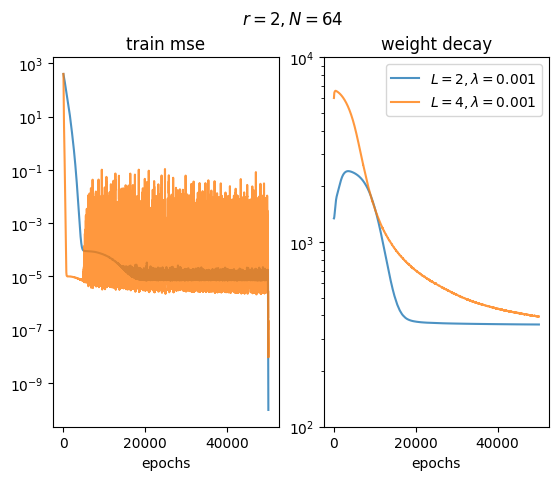

In [ ]:
optimalL2wd = 1e-3 # CHOOSE MANUALLY
optimalL4wd = 1e-3 # CHOOSE MANUALLY
alpha = 0.8
plt.subplot(121)
plt.semilogy(res[2][optimalL2wd]['trainmse'].cpu(),alpha=alpha)
plt.semilogy(res[4][optimalL4wd]['trainmse'].cpu(),alpha=alpha)
plt.title("train mse")
plt.xlabel("epochs")
plt.subplot(122)
plt.semilogy(res[2][optimalL2wd]['weightdecay'].cpu(),label=rf"$L = 2,\lambda = {optimalL2wd}$",alpha=alpha)
plt.semilogy(res[4][optimalL4wd]['weightdecay'].cpu(),label=rf"$L = 4,\lambda = {optimalL4wd}$",alpha=alpha)
plt.title('weight decay')
plt.ylim(1e2,1e4)
plt.xlabel("epochs")
plt.suptitle(rf"$r = {r}, N = {datasetsize}$")
plt.legend()

## $r = 2, N = 256$

### training for each value of lambda

In [ ]:
wds = np.logspace(-5,-3,num=3)
print(wds)
r = 2
datasetsize = 256
print(f"r = {r}, N = {datasetsize}")
res = {}
for L in [2,4]:
    print(f"~~L = {L}~~")
    res[L] = {}
    for wd in wds:
        result = train_L_layers(datasetsize,L,r,weight_decay=wd,epochs=50_100,normal=True,
                                lr=1e-4,scheduler=MultiStepLR,milestones=[50_000], gamma=0.1,verbose=False)
        res[L][wd] = result
        print(f"weight decay {wd:.2e}, test mse {result['testmse']:.6e} final train mse {result['trainmse'][-1].item():.6e}")


[1.e-05 1.e-04 1.e-03]
r = 2, N = 256
~~L = 2~~
weight decay 1.00e-05, test mse 5.757977e+01 final train mse 5.399089e-10
weight decay 1.00e-04, test mse 5.186653e+01 final train mse 9.014581e-09
weight decay 1.00e-03, test mse 4.671657e+01 final train mse 5.370113e-06
~~L = 4~~
weight decay 1.00e-05, test mse 1.491268e+01 final train mse 3.289384e-06
weight decay 1.00e-04, test mse 1.301165e+01 final train mse 2.466207e-05
weight decay 1.00e-03, test mse 3.890944e+00 final train mse 2.479585e-05


### saving results

In [ ]:
path = f"gdrive/MyDrive/TeacherNetworkResults/normaldist"
for value_to_save in ['trainmse','weightdecay','learningrate','testmse']:
    print(value_to_save)
    value_dict = {L:{} for L in [2,4]}
    for L in [2,4]:
        for wd in wds:
            print(L,wd)
            if type(res[L][wd][value_to_save]) == torch.Tensor:
                value = res[L][wd][value_to_save].clone().detach().cpu().numpy()
            else:
                value = res[L][wd][value_to_save].copy()
            value_dict[L][wd] = value
    np.save(f"{path}{value_to_save}_r{r}_N{datasetsize}",value_dict)
#save trained models
value_dict = {L:{} for L in [2,4]}
print('models')
for L in [2,4]:
    for wd in wds:
        print(L,wd)
        model = res[L][wd]['model'].cpu()
        torch.save(model.state_dict(), f"{path}model_r{r}_N{datasetsize}_L{L}_wd{wd}")

trainmse
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
weightdecay
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
learningrate
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
testmse
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
models
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001


### training plots

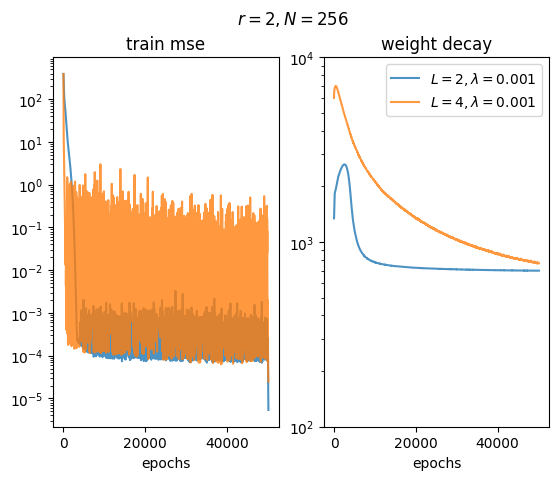

In [ ]:
optimalL2wd = 1e-3 # CHOOSE MANUALLY
optimalL4wd = 1e-3 # CHOOSE MANUALLY
alpha = 0.8
plt.subplot(121)
plt.semilogy(res[2][optimalL2wd]['trainmse'].cpu(),alpha=alpha)
plt.semilogy(res[4][optimalL4wd]['trainmse'].cpu(),alpha=alpha)
plt.title("train mse")
plt.xlabel("epochs")
plt.subplot(122)
plt.semilogy(res[2][optimalL2wd]['weightdecay'].cpu(),label=rf"$L = 2,\lambda = {optimalL2wd}$",alpha=alpha)
plt.semilogy(res[4][optimalL4wd]['weightdecay'].cpu(),label=rf"$L = 4,\lambda = {optimalL4wd}$",alpha=alpha)
plt.title('weight decay')
plt.ylim(1e2,1e4)
plt.xlabel("epochs")
plt.suptitle(rf"$r = {r}, N = {datasetsize}$")
plt.legend()

## $r = 2, N = 512$

### training for each value of lambda

In [ ]:
wds = np.logspace(-5,-3,num=3)
print(wds)
r = 2
datasetsize = 512
print(f"r = {r}, N = {datasetsize}")
res = {}
for L in [2,4]:
    print(f"~~L = {L}~~")
    res[L] = {}
    for wd in wds:
        result = train_L_layers(datasetsize,L,r,weight_decay=wd,epochs=50_100,normal=True,
                                lr=1e-4,scheduler=MultiStepLR,milestones=[50_000], gamma=0.1,verbose=False)
        res[L][wd] = result
        print(f"weight decay {wd:.2e}, test mse {result['testmse']:.6e} final train mse {result['trainmse'][-1].item():.6e}")


[1.e-05 1.e-04 1.e-03]
r = 2, N = 512
~~L = 2~~
weight decay 1.00e-05, test mse 3.268526e+01 final train mse 1.820685e-08
weight decay 1.00e-04, test mse 2.885873e+01 final train mse 1.401408e-07
weight decay 1.00e-03, test mse 2.547874e+01 final train mse 3.353017e-05
~~L = 4~~
weight decay 1.00e-05, test mse 3.999386e+00 final train mse 1.045495e-05
weight decay 1.00e-04, test mse 2.606058e+00 final train mse 1.206990e-06
weight decay 1.00e-03, test mse 9.002210e-02 final train mse 6.224695e-04


### saving results

In [ ]:
path = f"gdrive/MyDrive/TeacherNetworkResults/normaldist"
for value_to_save in ['trainmse','weightdecay','learningrate','testmse']:
    print(value_to_save)
    value_dict = {L:{} for L in [2,4]}
    for L in [2,4]:
        for wd in wds:
            print(L,wd)
            if type(res[L][wd][value_to_save]) == torch.Tensor:
                value = res[L][wd][value_to_save].clone().detach().cpu().numpy()
            else:
                value = res[L][wd][value_to_save].copy()
            value_dict[L][wd] = value
    np.save(f"{path}{value_to_save}_r{r}_N{datasetsize}",value_dict)
#save trained models
value_dict = {L:{} for L in [2,4]}
print('models')
for L in [2,4]:
    for wd in wds:
        print(L,wd)
        model = res[L][wd]['model'].cpu()
        torch.save(model.state_dict(), f"{path}model_r{r}_N{datasetsize}_L{L}_wd{wd}")

trainmse
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
weightdecay
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
learningrate
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
testmse
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001
models
2 1e-05
2 0.0001
2 0.001
4 1e-05
4 0.0001
4 0.001


### training plots

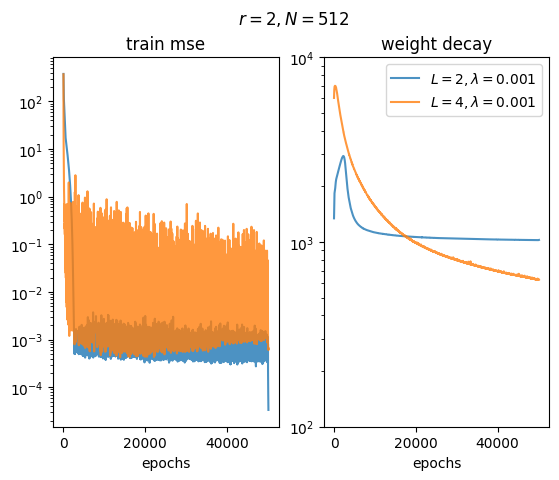

In [ ]:
optimalL2wd = 1e-3 # CHOOSE MANUALLY
optimalL4wd = 1e-3 # CHOOSE MANUALLY
alpha = 0.8
plt.subplot(121)
plt.semilogy(res[2][optimalL2wd]['trainmse'].cpu(),alpha=alpha)
plt.semilogy(res[4][optimalL4wd]['trainmse'].cpu(),alpha=alpha)
plt.title("train mse")
plt.xlabel("epochs")
plt.subplot(122)
plt.semilogy(res[2][optimalL2wd]['weightdecay'].cpu(),label=rf"$L = 2,\lambda = {optimalL2wd}$",alpha=alpha)
plt.semilogy(res[4][optimalL4wd]['weightdecay'].cpu(),label=rf"$L = 4,\lambda = {optimalL4wd}$",alpha=alpha)
plt.title('weight decay')
plt.ylim(1e2,1e4)
plt.xlabel("epochs")
plt.suptitle(rf"$r = {r}, N = {datasetsize}$")
plt.legend()

In [ ]:
endtime = time.time() - starttime
endtime

9726.770832777023